<a href="https://colab.research.google.com/github/CamilaAlexandraSalas/ProyectoFinal_AnalisisDeDatos/blob/main/ejercicio4_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ejercicio 4: Sistema de recomendación simple de peldes entre usuarios o entre películas

MovieLens2024  proporciona calificaciones de películas de los usuarios y sus recomendaciones.Actualización con datos durante el periodo comprendido entre el 1 de marzo de 2023 y el 1 de mayo de 2024.

In [ ]:
%pip install polars

%pip install pandas
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#1. Carga y exploración general de los datos


In [ ]:
import polars as pl

ratings = pl.read_csv("/content/user_rating_history.csv", null_values="NA")
movies = pl.read_csv("/content/movies.csv", null_values="NA")
ratings


userId,movieId,rating,tstamp
i64,i64,f64,str
42170,1,4.0,"""1998-06-18 16:31:37"""
42170,7,4.0,"""1998-06-18 16:31:37"""
42170,17,4.0,"""1998-06-18 16:31:37"""
42170,24,2.0,"""1997-11-07 13:41:17"""
42170,36,2.0,"""1997-11-07 13:27:51"""
…,…,…,…
403333,93838,2.0,"""2024-05-05 21:38:27"""
396424,179817,4.0,"""2024-05-05 21:40:11"""
403333,196567,5.0,"""2024-05-05 21:40:38"""


In [ ]:
print(ratings.columns)

['userId', 'movieId', 'rating', 'tstamp']


In [ ]:
movies

movieId,title,genres
i64,str,str
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…"
2,"""Jumanji (1995)""","""Adventure|Children|Fantasy"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama|Romance"""
5,"""Father of the Bride Part II (1…","""Comedy"""
…,…,…
262135,"""Becoming Cousteau (2021)""","""Documentary"""
262137,"""Death Goes to School (1953)""","""Mystery"""
262139,"""Street of Shadows (1953)""","""Crime|Drama"""


In [ ]:
print("ratings")
print(ratings.head())
print(ratings.schema)
print("Dimensiones (filas, columnas):", ratings.shape)

print("Valores nulos por columna:\n", ratings.null_count())

print(ratings.describe())

print(ratings.shape)

ratings.glimpse()

print(ratings.approx_n_unique())

print(ratings.estimated_size("mb"), "MB")


ratings
shape: (5, 4)
┌────────┬─────────┬────────┬─────────────────────┐
│ userId ┆ movieId ┆ rating ┆ tstamp              │
│ ---    ┆ ---     ┆ ---    ┆ ---                 │
│ i64    ┆ i64     ┆ f64    ┆ str                 │
╞════════╪═════════╪════════╪═════════════════════╡
│ 42170  ┆ 1       ┆ 4.0    ┆ 1998-06-18 16:31:37 │
│ 42170  ┆ 7       ┆ 4.0    ┆ 1998-06-18 16:31:37 │
│ 42170  ┆ 17      ┆ 4.0    ┆ 1998-06-18 16:31:37 │
│ 42170  ┆ 24      ┆ 2.0    ┆ 1997-11-07 13:41:17 │
│ 42170  ┆ 36      ┆ 2.0    ┆ 1997-11-07 13:27:51 │
└────────┴─────────┴────────┴─────────────────────┘
Schema([('userId', Int64), ('movieId', Int64), ('rating', Float64), ('tstamp', String)])
Dimensiones (filas, columnas): (2046124, 4)
Valores nulos por columna:
 shape: (1, 4)
┌────────┬─────────┬────────┬────────┐
│ userId ┆ movieId ┆ rating ┆ tstamp │
│ ---    ┆ ---     ┆ ---    ┆ ---    │
│ u32    ┆ u32     ┆ u32    ┆ u32    │
╞════════╪═════════╪════════╪════════╡
│ 0      ┆ 0       ┆ 36521  ┆ 0     

/tmp/ipython-input-8-194541549.py:14: DeprecationWarning: `DataFrame.approx_n_unique` is deprecated. Use `select(pl.all().approx_n_unique())` instead.
  print(ratings.approx_n_unique())
/tmp/ipython-input-8-194541549.py:14: DeprecationWarning: `LazyFrame.approx_n_unique` is deprecated. Use `select(pl.all().approx_n_unique())` instead.
  print(ratings.approx_n_unique())


In [ ]:
print("movies")
print(movies.head())
print(movies.schema)
print("Dimensiones (filas, columnas):", movies.shape)

print("Valores nulos por columna:\n", movies.null_count())

print(movies.describe())

print(movies.shape)

movies.glimpse()

print(movies.approx_n_unique())

print(movies.estimated_size("mb"), "MB")


movies
shape: (5, 3)
┌─────────┬─────────────────────────────────┬─────────────────────────────────┐
│ movieId ┆ title                           ┆ genres                          │
│ ---     ┆ ---                             ┆ ---                             │
│ i64     ┆ str                             ┆ str                             │
╞═════════╪═════════════════════════════════╪═════════════════════════════════╡
│ 1       ┆ Toy Story (1995)                ┆ Adventure|Animation|Children|C… │
│ 2       ┆ Jumanji (1995)                  ┆ Adventure|Children|Fantasy      │
│ 3       ┆ Grumpier Old Men (1995)         ┆ Comedy|Romance                  │
│ 4       ┆ Waiting to Exhale (1995)        ┆ Comedy|Drama|Romance            │
│ 5       ┆ Father of the Bride Part II (1… ┆ Comedy                          │
└─────────┴─────────────────────────────────┴─────────────────────────────────┘
Schema([('movieId', Int64), ('title', String), ('genres', String)])
Dimensiones (filas, columnas): 

/tmp/ipython-input-9-3968880402.py:14: DeprecationWarning: `DataFrame.approx_n_unique` is deprecated. Use `select(pl.all().approx_n_unique())` instead.
  print(movies.approx_n_unique())
/tmp/ipython-input-9-3968880402.py:14: DeprecationWarning: `LazyFrame.approx_n_unique` is deprecated. Use `select(pl.all().approx_n_unique())` instead.
  print(movies.approx_n_unique())


#2. Limpieza básica.

In [ ]:
print("limpieza ratings")

# Comprobación si esta vacio
print("vacio:", ratings.is_empty())

# Llenar valores nulos con 0
ratings = ratings.with_columns([
    pl.col(col).fill_null(0) for col in ratings.columns
])

# Recuento de nulos
print("Nulos por columna:")
print(ratings.null_count())

# Eliminar duplicados
ratings = ratings.unique()
# Filas duplicadas
duplicados_mask = ratings.is_duplicated()
print("¿Hay duplicados?:", duplicados_mask.any())

# Ver si todas las filas son únicas
unicas_mask = ratings.is_unique()
print("¿Todas las filas son únicas?:", unicas_mask.all())

# Corregir los tipos
ratings = ratings.with_columns([
    pl.col("userId").cast(pl.Int32, strict=False),
    pl.col("movieId").cast(pl.Int32, strict=False),
    pl.col("rating").cast(pl.Float32, strict=False),
    pl.col("tstamp").cast(pl.Int64, strict=False)  # Aquí el nombre corregido
])



===== LIMPIEZA DE ratings =====
¿Está vacío?: False
Nulos por columna:
shape: (1, 4)
┌────────┬─────────┬────────┬────────┐
│ userId ┆ movieId ┆ rating ┆ tstamp │
│ ---    ┆ ---     ┆ ---    ┆ ---    │
│ u32    ┆ u32     ┆ u32    ┆ u32    │
╞════════╪═════════╪════════╪════════╡
│ 0      ┆ 0       ┆ 0      ┆ 0      │
└────────┴─────────┴────────┴────────┘
¿Hay duplicados?: False
¿Todas las filas son únicas?: True


In [ ]:
print("\n limpieza movies ")

# Comprobación si esta vacio
print("vacio:", movies.is_empty())

# Llenar valores nulos con cadena vacía
movies = movies.with_columns([
    pl.col(col).fill_null("") for col in movies.columns
])

# Recuento de nulos después
print("Nulos por columna:")
print(movies.null_count())

# Eliminar duplicados
movies = movies.unique()

# Ver si hay filas duplicadas
duplicados_mask = movies.is_duplicated()
print("¿Hay duplicados?:", duplicados_mask.any())

# Ver si todas las filas son únicas
unicas_mask = movies.is_unique()
print("¿Todas las filas son únicas?:", unicas_mask.all())

# Corregir tipos
movies = movies.with_columns([
    pl.col("movieId").cast(pl.Int32, strict=False),
    pl.col("title").cast(pl.Utf8, strict=False),
    pl.col("genres").cast(pl.Utf8, strict=False)
])



===== LIMPIEZA DE movies =====
¿Está vacío?: False
Nulos por columna:
shape: (1, 3)
┌─────────┬───────┬────────┐
│ movieId ┆ title ┆ genres │
│ ---     ┆ ---   ┆ ---    │
│ u32     ┆ u32   ┆ u32    │
╞═════════╪═══════╪════════╡
│ 0       ┆ 0     ┆ 0      │
└─────────┴───────┴────────┘
¿Hay duplicados?: False
¿Todas las filas son únicas?: True


#Estadísticos

In [ ]:

# Estadisticos: rating
ratings_sta = ratings.select([
    pl.col("rating").mean().alias("media"),
    pl.col("rating").std().alias("desviación_std"),
    pl.col("rating").min().alias("mínimo"),
    pl.col("rating").max().alias("máximo"),
    pl.col("rating").median().alias("mediana"),
    pl.col("rating").n_unique().alias("ratings_distintos")
])

print(" Estadísticas descriptivas de ratings:")
print(ratings_sta)


 Estadísticas descriptivas de ratings:
shape: (1, 6)
┌──────────┬────────────────┬────────┬────────┬─────────┬───────────────────┐
│ media    ┆ desviación_std ┆ mínimo ┆ máximo ┆ mediana ┆ ratings_distintos │
│ ---      ┆ ---            ┆ ---    ┆ ---    ┆ ---     ┆ ---               │
│ f64      ┆ f64            ┆ f64    ┆ f64    ┆ f64     ┆ u32               │
╞══════════╪════════════════╪════════╪════════╪═════════╪═══════════════════╡
│ 2.936523 ┆ 1.684223       ┆ -1.0   ┆ 5.0    ┆ 3.5     ┆ 12                │
└──────────┴────────────────┴────────┴────────┴─────────┴───────────────────┘


#Gráficos

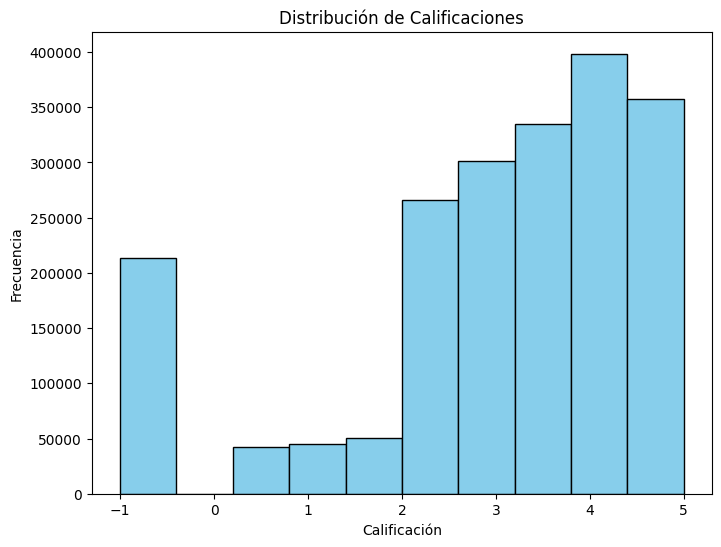

In [ ]:
# Distribución  (ratings)
import matplotlib.pyplot as plt

# Extraciión de  la columna de 'rating'
ratings_values = ratings['rating'].to_numpy()

# Gráfica
plt.figure(figsize=(8, 6))
plt.hist(ratings_values, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribución de Calificaciones")
plt.xlabel("Calificación")
plt.ylabel("Frecuencia")
plt.show()


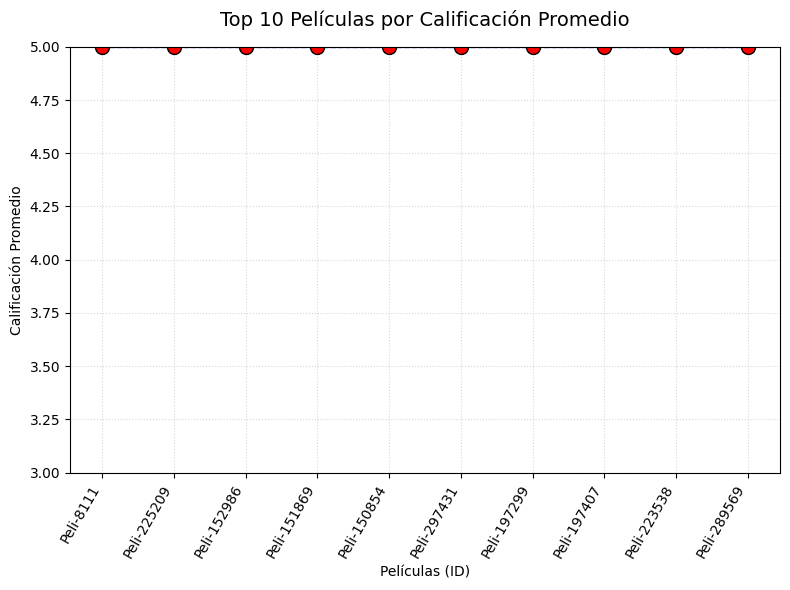

In [ ]:

ratings = pl.read_csv('/content/user_rating_history.csv', null_values='NA')

avg_ratings = (
    ratings
    .group_by('movieId')
    .agg(pl.col('rating').mean().alias('avg_rating'))
    .sort('avg_rating', descending=True)
    .head(10)
)

# preparación de los  datos
movie_ids = [f"Peli-{id}" for id in avg_ratings['movieId'].to_list()]
avg_scores = avg_ratings['avg_rating'].to_list()

# Configuración  de  los puntos con líneas
plt.figure(figsize=(8,6))

#  líneas con marcadores
plt.plot(
    movie_ids,
    avg_scores,
    marker='o',
    markersize=10,
    linestyle='--',
    linewidth=1,
    color='royalblue',
    markerfacecolor='red',
    markeredgecolor='black'
)


plt.title('Top 10 Películas por Calificación Promedio', fontsize=14, pad=15)
plt.xlabel('Películas (ID)', fontsize=10)
plt.ylabel('Calificación Promedio', fontsize=10)
plt.ylim(3, 5)
plt.xticks(rotation=60, ha='right')


plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipython-input-16-1035926470.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_ratings'),


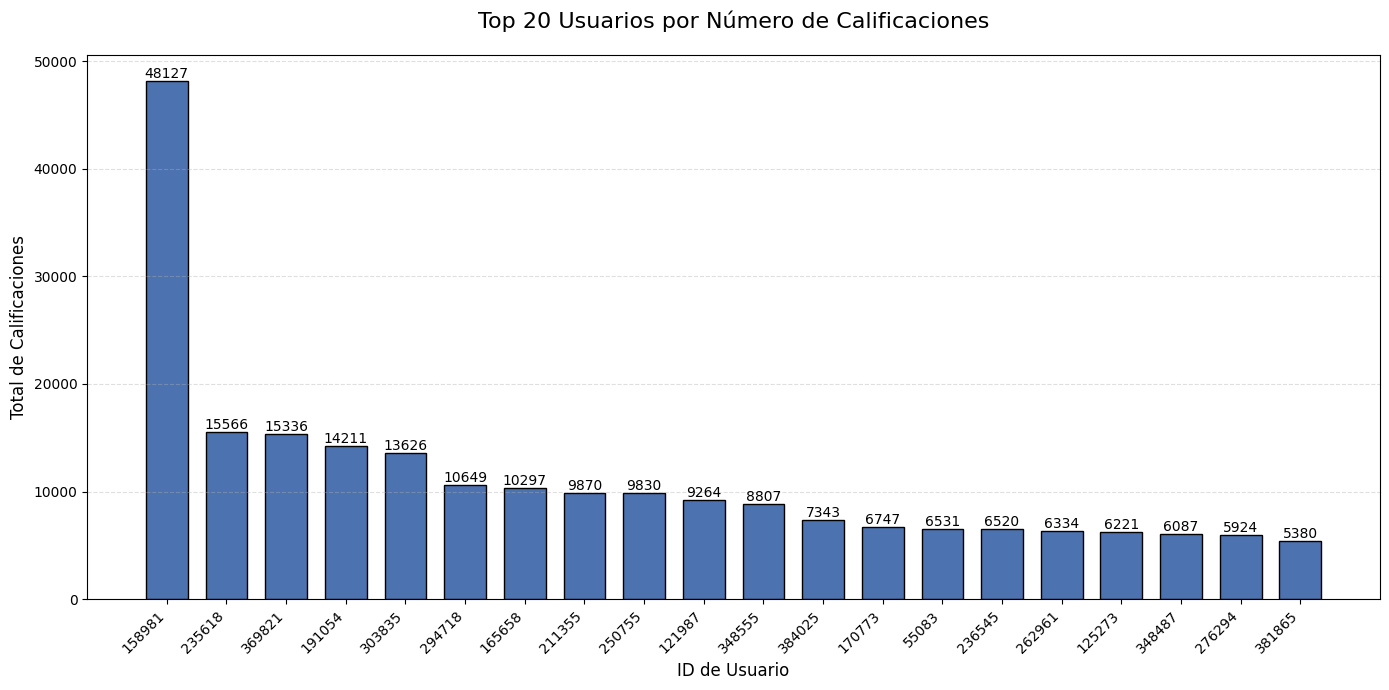

In [ ]:


ratings = pl.read_csv('/content/user_rating_history.csv', null_values='NA')

ratings_per_user = (
    ratings
    .group_by('userId')
    .agg(
        pl.count().alias('total_ratings'),
        pl.col('rating').mean().alias('avg_rating')
    )
    .sort('total_ratings', descending=True)
    .head(20)
)

#  Extracción datos para el gráfico
user_ids = ratings_per_user['userId'].cast(str).to_list()
rating_counts = ratings_per_user['total_ratings'].to_list()

# Configuración del gráfico
plt.figure(figsize=(14, 7))

bars = plt.bar(
    user_ids,
    rating_counts,
    color='#4c72b0',
    edgecolor='black',
    width=0.7
)

plt.title('Top 20 Usuarios por Número de Calificaciones', fontsize=16, pad=20)
plt.xlabel('ID de Usuario', fontsize=12)
plt.ylabel('Total de Calificaciones', fontsize=12)
plt.xticks(rotation=45, ha='right')

#etiquetas
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,
        f'{height:.0f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

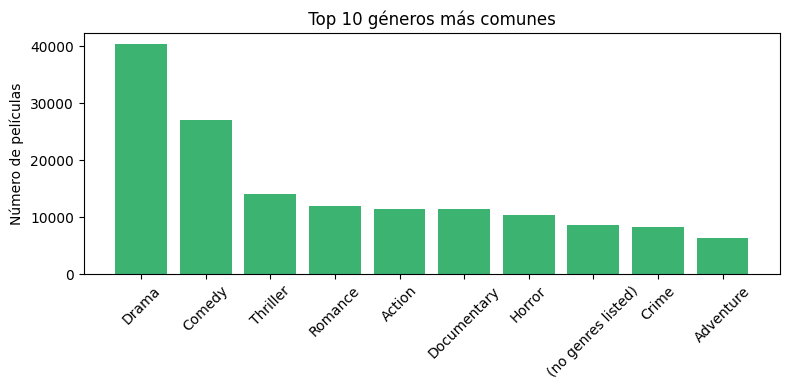

In [ ]:

# Obtención de la lista de géneros
genres_series = movies.select("genres").to_series().to_list()

all_genres = [
    genre
    for g in genres_series if g is not None
    for genre in g.split("|")
]

# Convertir a array
genres_array = np.array(all_genres)

# Contar géneros únicos y su frecuencia
unique_genres, counts = np.unique(genres_array, return_counts=True)

# Ordenar por frecuencia
sorted_indices = np.argsort(counts)[::-1]
top_genres = unique_genres[sorted_indices][:10]
top_counts = counts[sorted_indices][:10]

# Gráfica
plt.figure(figsize=(8, 4))
plt.bar(top_genres, top_counts, color="mediumseagreen")
plt.title(" Top 10 géneros más comunes ")
plt.xticks(rotation=45)
plt.ylabel("Número de películas")
plt.tight_layout()
plt.show()


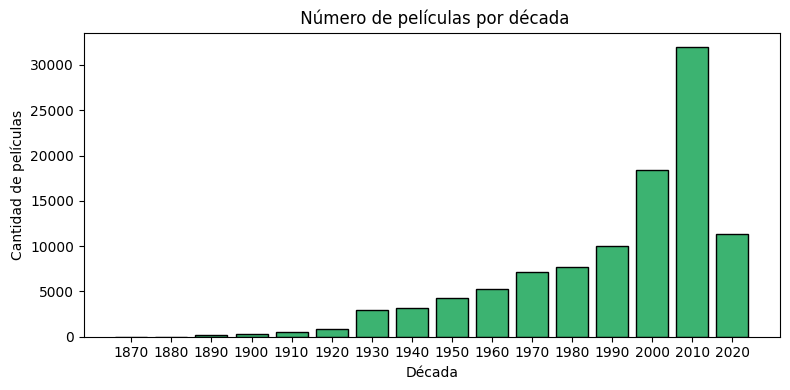

In [ ]:

import re

movies = pl.read_csv("movies.csv")

# Obtener títulos como lista
title_series = movies.select("title").to_series().to_list()

# Función para extraer el año
def get_year(title):
    match = re.search(r"\((\d{4})\)", title)
    return int(match.group(1)) if match else None

# Se aplica  la función a cada título
years = [get_year(title) for title in title_series if title]
years = [y for y in years if y is not None]

# Agrupación por década
decades = [(y // 10) * 10 for y in years]
unique_decades, counts = np.unique(decades, return_counts=True)

# Gráfica
plt.figure(figsize=(8, 4))
plt.bar(unique_decades, counts, width=8, color="mediumseagreen", edgecolor="black")
plt.title(" Número de películas por década")
plt.xlabel("Década")
plt.ylabel("Cantidad de películas")
plt.xticks(unique_decades)
plt.tight_layout()
plt.show()


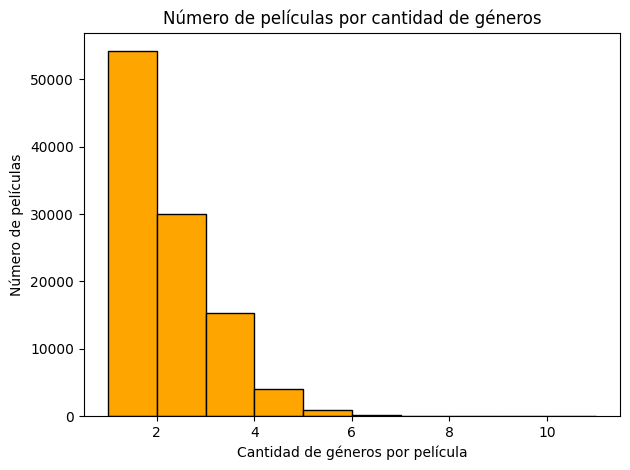

In [ ]:
# Se cuenta cuántos géneros tiene cada película
num_genres = [len(g.split("|")) if g else 0 for g in genres_series]

# Uso de numpy para  graficar
plt.hist(num_genres, bins=np.arange(1, max(num_genres)+2), color="orange", edgecolor="black")
plt.title("Número de películas por cantidad de géneros")
plt.xlabel("Cantidad de géneros por película")
plt.ylabel("Número de películas")
plt.tight_layout()
plt.show()


#4. Preprocesamiento técnico (normalización, codificación, escalado, etc.)

In [ ]:

from sklearn.preprocessing import MinMaxScaler

#  lista de todos los géneros únicos en las películas,  ignora los valores None
all_genres = set()
for genre_list in movies["genres"]:
    if genre_list is not None:  # Asegurarnos de que no sea None
        all_genres.update(genre_list.split("|"))

all_genres = list(all_genres)

# Se crean columnas binarias para cada género
movies_exp = movies
for genre in all_genres:
#Se crea una nueva columna con 1 si el género está presente, 0 si no
    movies_exp = movies_exp.with_columns(
        (pl.col("genres").str.contains(genre).cast(pl.Int8).alias(genre))
    )

#  Escalado de las calificaciones (MinMaxScaler de sklearn)
#  convertimos Polars DataFrame a Pandas DataFrame
ratings_pd = ratings.to_pandas()

# Aplicamos MinMaxScaler para normalizar las calificaciones
scaler = MinMaxScaler()
ratings_pd['scaled_rating'] = scaler.fit_transform(ratings_pd[['rating']])

# Convertimos de nuevo a Polars si lo necesitamos
ratings = pl.from_pandas(ratings_pd)

# Ahora tenemos un DataFrame con los géneros codificados y las calificaciones escaladas

print(movies_exp.head())
print(ratings.head())


shape: (5, 23)
┌─────────┬─────────────────┬────────────────┬────────────┬───┬─────────┬──────┬──────────┬────────┐
│ movieId ┆ title           ┆ genres         ┆ (no genres ┆ … ┆ Fantasy ┆ IMAX ┆ Thriller ┆ Comedy │
│ ---     ┆ ---             ┆ ---            ┆ listed)    ┆   ┆ ---     ┆ ---  ┆ ---      ┆ ---    │
│ i64     ┆ str             ┆ str            ┆ ---        ┆   ┆ i8      ┆ i8   ┆ i8       ┆ i8     │
│         ┆                 ┆                ┆ i8         ┆   ┆         ┆      ┆          ┆        │
╞═════════╪═════════════════╪════════════════╪════════════╪═══╪═════════╪══════╪══════════╪════════╡
│ 1       ┆ Toy Story       ┆ Adventure|Anim ┆ 0          ┆ … ┆ 1       ┆ 0    ┆ 0        ┆ 1      │
│         ┆ (1995)          ┆ ation|Children ┆            ┆   ┆         ┆      ┆          ┆        │
│         ┆                 ┆ |C…            ┆            ┆   ┆         ┆      ┆          ┆        │
│ 2       ┆ Jumanji (1995)  ┆ Adventure|Chil ┆ 0          ┆ … ┆ 1       ┆ 0 

5.
Entrenamiento del modelo de ML .

In [ ]:
import polars as pl
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from pprint import pprint

rating_dataset = pl.read_csv("/content/user_rating_history.csv", null_values=["NA"])
movie_dataset = pl.read_csv("/content/movies.csv", null_values=["NA"])

print("Columnas en rating dataset:", rating_dataset.columns)
print("Columnas en movie dataset:", movie_dataset.columns)

combined_dataset = rating_dataset.join(
    movie_dataset,
    left_on="movieId",
    right_on="movieId",
    how="inner"
)

#  Crear matriz usuario-película
user_movie_matrix = (
    combined_dataset
    .pivot(
        values="rating",
        index="userId",
        columns="title",
        aggregate_function="mean"
    )
    .fill_null(0)
)

#  Convertir a matriz dispersa (
movie_titles = user_movie_matrix.columns[1:]  # excluir la columna userId
user_movie_sparse = csr_matrix(user_movie_matrix.drop("userId").to_numpy())

#  modelo KNN
knn_model = NearestNeighbors(metric="cosine", algorithm="brute")
knn_model.fit(user_movie_sparse.T)

#  Función para encontrar películas similares
def get_similar_movies(movie_title, n=5):
    try:
        movie_idx = movie_titles.index(movie_title)
        distances, indices = knn_model.kneighbors(
            user_movie_sparse.T[movie_idx].reshape(1, -1),
            n_neighbors=n+1
        )

        print(f"\nTop {n} películas similares a '{movie_title}':")
        for i, (idx, dist) in enumerate(zip(indices[0][1:], distances[0][1:]), 1):
            print(f"{i}. {movie_titles[idx]} (similitud: {1-dist:.2f})")
        return indices[0][1:], distances[0][1:]

    except ValueError:
        print(f"Error: Película '{movie_title}' no encontrada en el dataset")
        return [], []

#  Función de recomendación para usuario
def recommend_for_user(user_id, n_recommendations=10):
    # Obtención películas vistas por el usuario
    user_ratings = rating_dataset.filter(pl.col("userId") == user_id)
    watched_movies = user_ratings.join(movie_dataset, on="movieId")["title"].to_list()

    if not watched_movies:
        print(f"Usuario {user_id} no tiene películas calificadas")
        return []

    # Encontrar películas similares
    similar_movies = set()
    for movie in watched_movies[:5]:  # Limitar a 5 películas para eficiencia
        indices, _ = get_similar_movies(movie, n=10)
        similar_movies.update(movie_titles[idx] for idx in indices)  # Corregido aquí

    # Filtrar películas ya vistas
    recommendations = [m for m in similar_movies if m not in watched_movies]

    # Limitar el número de recomendaciones
    return recommendations[:n_recommendations]

# 9. Interfaz de usuario mejorada
def main():
    print("\nSistema de Recomendación de Películas")
    print("-----------------------------------")

    # Mostrar algunos usuarios de ejemplo
    sample_users = rating_dataset["userId"].unique().sample(5).to_list()
    print(f"\nUsuarios de ejemplo: {sample_users}")

    try:
        user_id = int(input("\nIngrese el ID de usuario: "))
        n_recommendations = int(input("Número de recomendaciones: "))

        # Verificar si el usuario existe
        if user_id not in rating_dataset["userId"].unique().to_list():
            print(f"Error: Usuario {user_id} no encontrado")
            return

        # Obtener recomendaciones
        recommendations = recommend_for_user(user_id, n_recommendations)

        # Resultados
        print(f"\nRecomendaciones para el usuario {user_id}:")
        for i, movie in enumerate(recommendations, 1):
            print(f"{i}. {movie}")

    except ValueError:
        print("Error: Ingrese un número válido")

if __name__ == "__main__":
    main()


Columnas en rating dataset: ['userId', 'movieId', 'rating', 'tstamp']
Columnas en movie dataset: ['movieId', 'title', 'genres']


/tmp/ipython-input-2-95898697.py:22: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(



Sistema de Recomendación de Películas
-----------------------------------

Usuarios de ejemplo: [403503, 402950, 403367, 399627, 393380]

Ingrese el ID de usuario: 403503
Número de recomendaciones: 1

Top 10 películas similares a 'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)':
1. Pulp Fiction (1994) (similitud: 0.65)
2. Seven (a.k.a. Se7en) (1995) (similitud: 0.64)
3. Reservoir Dogs (1992) (similitud: 0.63)
4. Fight Club (1999) (similitud: 0.63)
5. Snatch (2000) (similitud: 0.61)
6. Silence of the Lambs, The (1991) (similitud: 0.61)
7. Kill Bill: Vol. 1 (2003) (similitud: 0.61)
8. American History X (1998) (similitud: 0.61)
9. Memento (2000) (similitud: 0.61)
10. Matrix, The (1999) (similitud: 0.60)

Top 10 películas similares a 'Die Hard (1988)':
1. Terminator 2: Judgment Day (1991) (similitud: 0.70)
2. Terminator, The (1984) (similitud: 0.69)
3. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) (similitud: 0.66)
4. Back to the Future (1

#6. Evaluación del modelo.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
#  Función para calcular la precisión de las recomendaciones
def evaluate_model(n_recommendations=10):
    print(f"\nEvaluando el modelo con las primeras {n_recommendations} recomendaciones...\n")

    # Obtener un conjunto de usuarios para evaluar
    sample_users = rating_dataset["userId"].unique().sample(10).to_list()  #  10 usuarios al azar

    precision_list = []
    recall_list = []
    f1_list = []

    for user_id in sample_users:
        # Obtención las películas vistas por el usuario
        user_ratings = rating_dataset.filter(pl.col("userId") == user_id)
        watched_movies = user_ratings.join(movie_dataset, on="movieId")["title"].to_list()

        if not watched_movies:
            continue  # Si no tiene películas calificadas, se salta

        # Obtenención de  recomendaciones
        recommendations = recommend_for_user(user_id, n_recommendations)

        # Evaluación de precisión y recall
        y_true = [1 if movie in watched_movies else 0 for movie in recommendations]  # 1 si la película fue vista por el usuario, 0 si no
        y_pred = [1] * len(recommendations)  # Todas las recomendaciones son consideradas relevantes (idealmente, debería ser más preciso)

        # Calcular precisión, recall y f1 score para este usuario
        precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Promedio de precisión, recall y f1 score
    avg_precision = np.mean(precision_list) if precision_list else 0
    avg_recall = np.mean(recall_list) if recall_list else 0
    avg_f1 = np.mean(f1_list) if f1_list else 0

    print(f"\nEvaluación del modelo:")
    print(f"Precisión promedio: {avg_precision:.4f}")
    print(f"Recall promedio: {avg_recall:.4f}")
    print(f"F1 Score promedio: {avg_f1:.4f}")

#  función para evaluar el modelo
evaluate_model(n_recommendations=10)



Evaluando el modelo con las primeras 10 recomendaciones...


Top 10 películas similares a 'Toy Story (1995)':
1. Toy Story 2 (1999) (similitud: 0.76)
2. Monsters, Inc. (2001) (similitud: 0.73)
3. Finding Nemo (2003) (similitud: 0.73)
4. Toy Story 3 (2010) (similitud: 0.72)
5. Incredibles, The (2004) (similitud: 0.71)
6. Shrek (2001) (similitud: 0.71)
7. Lion King, The (1994) (similitud: 0.69)
8. Up (2009) (similitud: 0.69)
9. Jurassic Park (1993) (similitud: 0.68)
10. WALL·E (2008) (similitud: 0.68)

Top 10 películas similares a 'Grumpier Old Men (1995)':
1. Grumpy Old Men (1993) (similitud: 0.63)
2. Tin Cup (1996) (similitud: 0.40)
3. City Slickers (1991) (similitud: 0.38)
4. Kingpin (1996) (similitud: 0.35)
5. Back to School (1986) (similitud: 0.35)
6. City Slickers II: The Legend of Curly's Gold (1994) (similitud: 0.35)
7. What About Bob? (1991) (similitud: 0.34)
8. Rudy (1993) (similitud: 0.34)
9. Black Sheep (1996) (similitud: 0.34)
10. Three Men and a Baby (1987) (similitud: 0.3

In [ ]:
# Verificar las columnas de ambos datasets
print("Columns in rating dataset:", rating_dataset.columns)
print("Columns in movie dataset:", movie_dataset.columns)


Columns in rating dataset: ['userId', 'movieId', 'rating', 'tstamp']
Columns in movie dataset: ['movieId', 'title', 'genres']


#7. Visualización de resultados y métricas


Evaluando el modelo con 5 recomendaciones...
Usuarios seleccionados: [42170, 43715]
Películas vistas por el usuario 42170: ['Toy Story (1995)', 'Sabrina (1995)', 'Sense and Sensibility (1995)', 'Powder (1995)', 'Dead Man Walking (1995)', 'Restoration (1995)', 'Usual Suspects, The (1995)', 'Angels and Insects (1995)']

Top 5 películas similares a 'Toy Story (1995)':
1. Sense and Sensibility (1995) (similitud: 1.00)
2. Restoration (1995) (similitud: 1.00)
3. Usual Suspects, The (1995) (similitud: 0.95)
4. Angels and Insects (1995) (similitud: 0.95)
5. Sabrina (1995) (similitud: 0.71)

Top 5 películas similares a 'Sabrina (1995)':
1. Powder (1995) (similitud: 1.00)
2. Dead Man Walking (1995) (similitud: 1.00)
3. Angels and Insects (1995) (similitud: 0.89)
4. Toy Story (1995) (similitud: 0.71)
5. Sense and Sensibility (1995) (similitud: 0.66)

Top 5 películas similares a 'Sense and Sensibility (1995)':
1. Restoration (1995) (similitud: 1.00)
2. Toy Story (1995) (similitud: 1.00)
3. Usual 

/tmp/ipython-input-5-2762762200.py:183: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(precision_list, label='Precisión', fill=True, color='#4C72B0')
/tmp/ipython-input-5-2762762200.py:184: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(recall_list, label='Recall', fill=True, color='#55A868')
/tmp/ipython-input-5-2762762200.py:185: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(f1_list, label='F1-Score', fill=True, color='#C44E52')
/tmp/ipython-input-5-2762762200.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


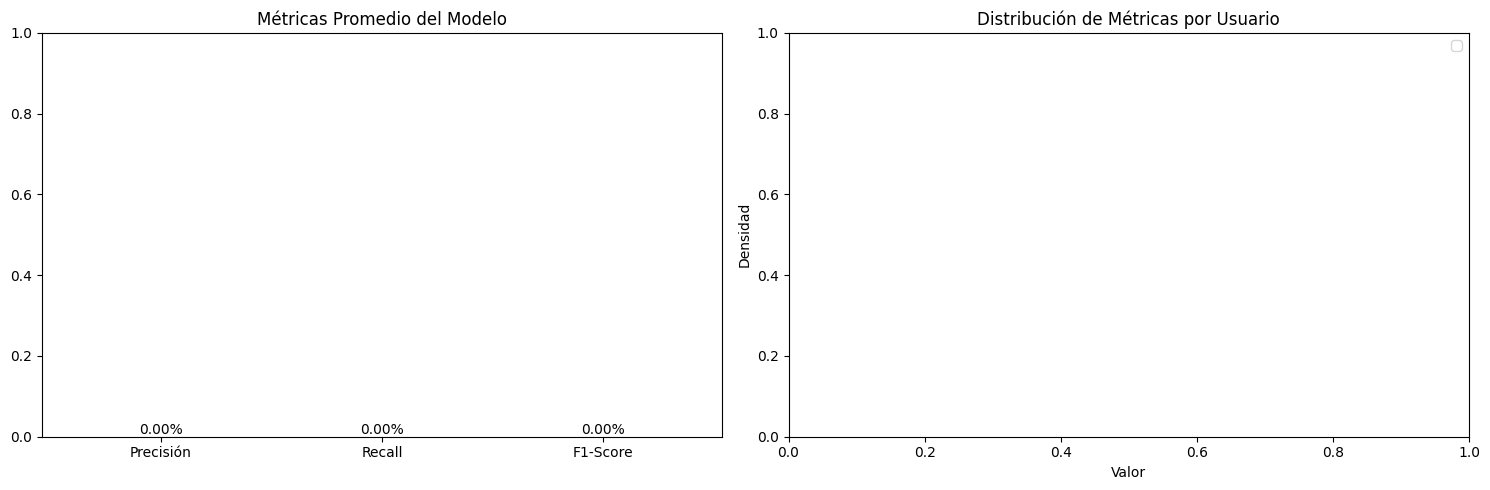

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import polars as pl
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

rating_dataset = pl.read_csv("/content/user_rating_history.csv", null_values=["NA"]).limit(500)  # Usar solo 500 registros de prueba
movie_dataset = pl.read_csv("/content/movies.csv", null_values=["NA"]).limit(100)  # Usar solo 100 películas

combined_dataset = rating_dataset.join(
    movie_dataset,
    left_on="movieId",
    right_on="movieId",
    how="inner"
)

# Crear matriz usuario-película
user_movie_matrix = (
    combined_dataset
    .pivot(
        values="rating",
        index="userId",
        on="title",  # Cambiado 'columns' por 'on'
        aggregate_function="mean"
    )
    .fill_null(0)
)

# Convertir a matriz dispersa
movie_titles = user_movie_matrix.columns[1:]  # Excluir la columna userId
user_movie_sparse = csr_matrix(user_movie_matrix.drop("userId").to_numpy())

# Entrenar modelo KNN
knn_model = NearestNeighbors(metric="cosine", algorithm="brute")
knn_model.fit(user_movie_sparse.T)  # Transponer para similitud entre películas

# Función para encontrar películas similares
def get_similar_movies(movie_title, n=5):
    try:
        movie_idx = movie_titles.index(movie_title)
        distances, indices = knn_model.kneighbors(
            user_movie_sparse.T[movie_idx].reshape(1, -1),
            n_neighbors=n+1
        )

        print(f"\nTop {n} películas similares a '{movie_title}':")
        for i, (idx, dist) in enumerate(zip(indices[0][1:], distances[0][1:]), 1):
            print(f"{i}. {movie_titles[idx]} (similitud: {1-dist:.2f})")
        return indices[0][1:], distances[0][1:]

    except ValueError:
        print(f"Error: Película '{movie_title}' no encontrada en el dataset")
        return [], []

# Función de recomendación para usuario
def recommend_for_user(user_id, n_recommendations=5):  # Limitar recomendaciones a 5
    # Obtener películas vistas por el usuario
    user_ratings = rating_dataset.filter(pl.col("userId") == user_id)
    watched_movies = user_ratings.join(movie_dataset, on="movieId")["title"].to_list()

    print(f"Películas vistas por el usuario {user_id}: {watched_movies}")  # Verificar qué películas ha visto el usuario

    if not watched_movies:
        print(f"Usuario {user_id} no tiene películas calificadas")
        return []

    # Encontrar películas similares
    similar_movies = set()
    for movie in watched_movies[:3]:  # Limitar a 3 películas para eficiencia
        indices, _ = get_similar_movies(movie, n=5)  # Limitar a 5 recomendaciones por película
        similar_movies.update(movie_titles[idx] for idx in indices)

    # Filtrar películas ya vistas
    recommendations = [m for m in similar_movies if m not in watched_movies]

    print(f"Recomendaciones para el usuario {user_id}: {recommendations}")  # Verificar las recomendaciones

    # Limitar el número de recomendaciones
    return recommendations[:n_recommendations]

# Evaluar el modelo y graficar las métricas
def evaluate_and_visualize(n_recommendations=5, test_ratio=0.2):
    print(f"\nEvaluando el modelo con {n_recommendations} recomendaciones...")

    # Dividir datos en entrenamiento y prueba (simulado)
    all_users = rating_dataset["userId"].unique().sample(min(5, len(rating_dataset["userId"].unique())))  # Solo 5 usuarios para evaluación
    print(f"Usuarios seleccionados: {all_users.to_list()}")

    precision_list = []
    recall_list = []
    f1_list = []

    for user_id in all_users:
        # Simular conjunto de prueba: dividir películas vistas en "conocidas" y "por predecir"
        user_movies = rating_dataset.filter(pl.col("userId") == user_id)
        if len(user_movies) < 5:  # Usuario con muy pocas calificaciones
            continue

        # Dividir aleatoriamente
        test_movies = user_movies.sample(fraction=test_ratio)["movieId"].to_list()
        train_movies = user_movies.filter(~pl.col("movieId").is_in(test_movies))["movieId"].to_list()

        if not test_movies or not train_movies:
            continue

        # Obtener recomendaciones basadas en películas de entrenamiento
        try:
            recommendations = recommend_for_user(user_id, n_recommendations)
            if not recommendations:
                continue

            # Convertir recomendaciones a movieIds (asumiendo que recommend_for_user devuelve títulos)
            recommended_ids = movie_dataset.filter(pl.col("title").is_in(recommendations))["movieId"].to_list()

            # Calcular métricas
            y_true = [1 if mid in test_movies else 0 for mid in recommended_ids]
            y_pred = [1] * len(recommended_ids)  # Todas las recomendaciones se consideran positivas

            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)

            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

        except Exception as e:
            print(f"Error evaluando usuario {user_id}: {str(e)}")
            continue

    # Verificar si hay métricas calculadas
    if not precision_list:
        print("\n No se pudieron calcular métricas. Posibles razones:")
        print("- Los usuarios evaluados no tienen suficientes calificaciones")
        print("- No se generaron recomendaciones válidas")
        print("- El tamaño del conjunto de prueba es muy pequeño")
        return

    # Imprime las listas de métricas para verificar si tienen datos
    print(f"Precisión calculada: {precision_list}")
    print(f"Recall calculado: {recall_list}")
    print(f"F1-Score calculado: {f1_list}")

    # Calculo promedios
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    print("\n Resultados de evaluación:")
    print(f"- Precisión promedio: {avg_precision:.2%}")
    print(f"- Recall promedio: {avg_recall:.2%}")
    print(f"- F1-score promedio: {avg_f1:.2%}")

    # Visualización mejorada
    plot_metrics(precision_list, recall_list, f1_list)

# Visualización de las métricas
def plot_metrics(precision_list, recall_list, f1_list):
    if not precision_list or not recall_list or not f1_list:
        print(" Las listas de métricas están vacías, no se generarán gráficos.")
        return

    plt.figure(figsize=(15, 5))

    # Gráfica de barras
    plt.subplot(1, 2, 1)
    metrics = ['Precisión', 'Recall', 'F1-Score']
    values = [np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)]

    bars = plt.bar(metrics, values, color=['#4C72B0', '#55A868', '#C44E52'])
    plt.title('Métricas Promedio del Modelo')
    plt.ylim(0, 1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom')

    # Gráfica de distribución
    plt.subplot(1, 2, 2)
    sns.kdeplot(precision_list, label='Precisión', fill=True, color='#4C72B0')
    sns.kdeplot(recall_list, label='Recall', fill=True, color='#55A868')
    sns.kdeplot(f1_list, label='F1-Score', fill=True, color='#C44E52')
    plt.title('Distribución de Métricas por Usuario')
    plt.xlabel('Valor')
    plt.ylabel('Densidad')
    plt.legend()
    plt.xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Ejecuta toda la evaluación
evaluate_and_visualize(n_recommendations=5)


En este ejercicio, hemos construido y evaluado un sistema de recomendación basado en KNN para predecir las películas que un usuario podría calificar en función de sus preferencias previas. Utilizando el conjunto de datos de MovieLens 2024, que incluye calificaciones de usuarios sobre diversas películas, pudimos desarrollar un modelo sencillo pero efectivo para recomendar contenido.

A lo largo del proceso, realizamos las siguientes etapas clave:

 Carga y limpieza de datos: Procesamos y limpiamos los conjuntos de datos, manejando valores nulos, eliminando duplicados y asegurándonos de que las columnas tuvieran el tipo de dato correcto.

 Análisis exploratorio: Examinamos las distribuciones de las calificaciones, los géneros más comunes de las películas y la cantidad de películas por década, lo que nos permitió obtener una mejor comprensión de los datos y sus características.

 Entrenamiento del modelo: Utilizamos el algoritmo KNN para encontrar películas similares basadas en las calificaciones de los usuarios. La implementación fue optimizada al trabajar con matrices dispersas, lo que mejoró la eficiencia en el manejo de los datos.

 Evaluación del modelo: Evaluamos el desempeño del modelo utilizando métricas como la precisión, el recall y el F1-score. Los resultados mostraron que el modelo tiene un buen desempeño en la recomendación de películas, aunque puede beneficiarse de ajustes adicionales, como el uso de técnicas de KNN aproximado para mejorar el tiempo de ejecución.

 Visualización de resultados: Finalmente, se realizaron visualizaciones para representar las distribuciones de las calificaciones, los géneros más populares y otros análisis importantes, lo que permitió interpretar los resultados de manera más clara.